In [1]:
from typing import List

import torch
import torch.cuda
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Union
from datetime import datetime

from PIL import Image as PILImage

import numpy as np
import pyml
from models import DiscriminatorPixelMse, DownSampler, GeneratorESPCN

In [2]:
torch.cuda.is_available()

True

In [3]:
dataset = pyml.ImagesDataset.from_dirs_recursive(roots=["datasets/flowers102processed"], channels_order='chw')
batch_size = 64

if torch.cuda.is_available():
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device='cuda')
else:
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
class GanHelper:
    def __init__(self, data_loader: DataLoader):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.data_loader = data_loader
        scale = 4
        self.generator = GeneratorESPCN(channels=128, upscale=scale).to(self.device)
        self.discriminator = DiscriminatorPixelMse(weight=1.0)
        self.downsampler = DownSampler(scale=scale).to(self.device)

        self.losses = []
        self.losses_print_step = 10

    def add_loss(self, loss: torch.Tensor):
        self.losses.append(loss.item())
        if self.losses_print_step is not None and len(self.losses) % self.losses_print_step == 0:
            av_loss = np.average(self.losses[-self.losses_print_step:])
            print(f"{len(self.losses)}: {av_loss}")

    def train(self, steps: int, lr: float):
        generator_optimizer = torch.optim.Adam([
            {'params': self.generator.layers.parameters()},
            {'params': self.generator.pixel_shuffle.parameters(), 'lr': lr * 0.1}
        ], lr=lr)
        self.generator.train()

        step = 0
        while True:
            for label in self.data_loader:
                label = label.to(self.device)
                x = self.downsampler(label)

                generator_optimizer.zero_grad()
                y = self.generator(x)

                loss = self.discriminator.loss(y, label)
                loss.backward()
                generator_optimizer.step()

                self.add_loss(loss)

                step += 1
                if step >= steps:
                    return

    def demonstrate(self, label: Union[np.ndarray, torch.Tensor]) -> PILImage:
        if isinstance(label, np.ndarray):
            if len(label.shape) == 3:
                label = label[np.newaxis]
            label = torch.from_numpy(label)
        assert isinstance(label, torch.Tensor)
        label = label.to(self.device)

        self.generator.eval()
        x = self.downsampler(label)
        y = self.generator(x)
        x4x = self.downsampler.upsample(x)

        triple = torch.cat([x4x, y, label], dim=3)
        pic = triple.cpu().detach().numpy()[0]
        pic = np.moveaxis(pic, 0, 2)
        pic = np.clip(pic, 0.0, 1.0)
        img = PILImage.fromarray((pic * 255.0).astype(np.uint8))
        return img

    def save_model(self) -> str:
        suffix = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
        torch.save(self.generator.state_dict(), f"models/espcn/generator_espcn_{suffix}.pth")
        return suffix

    def load_model(self, suffix: str):
        self.generator.load_state_dict(torch.load(f"models/espcn/generator_espcn_{suffix}.pth"))

In [5]:
gan_helper = GanHelper(data_loader)

/home/lgor/projects/2023/pyenv310/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [6]:
gan_helper.train(steps=5 * len(dataset) // batch_size, lr=0.001)

10: 0.10072883106768131
20: 0.031193150952458382
30: 0.020428677089512348
40: 0.015317104384303093
50: 0.012191488407552242
60: 0.010686107259243727
70: 0.009197957254946232


In [7]:
gan_helper.train(steps=20 * len(dataset) // batch_size, lr=0.0003)

80: 0.008410941902548074
90: 0.00985584817826748
100: 0.008185972040519119
110: 0.00769909187220037
120: 0.007506256038323045
130: 0.007148133311420679
140: 0.006651078118011355
150: 0.006541662942618131
160: 0.006211458472535014
170: 0.005815255222842097
180: 0.005553634371608496
190: 0.005219720490276814
200: 0.004957393044605851
210: 0.00479280180297792
220: 0.004593239491805434
230: 0.004299575672484934
240: 0.004306004755198956
250: 0.004249493498355151
260: 0.003921325854025781
270: 0.0038973075104877354
280: 0.003871634905226529
290: 0.003670438705012202
300: 0.0036652499809861185
310: 0.00362263813149184
320: 0.0036116919945925474
330: 0.0035447744885459542
340: 0.003463358827866614
350: 0.003465635096654296
360: 0.0033281307900324465
370: 0.0034655665047466757
380: 0.0033802951453253626
390: 0.0034259875072166325


In [8]:
gan_helper.train(steps=30 * len(dataset) // batch_size, lr=0.0001)

400: 0.0033339656656607985
410: 0.003664851747453213
420: 0.00332209593616426
430: 0.0033790995134040714
440: 0.0032390495063737033
450: 0.0033639535773545503
460: 0.0032384806545451283
470: 0.0031573390355333687
480: 0.0033602858427912
490: 0.0031181760132312775
500: 0.003196057165041566
510: 0.0032677558483555913
520: 0.003216230240650475
530: 0.0033086640760302544
540: 0.003112557320855558
550: 0.0031594613799825312
560: 0.0032025873195379974
570: 0.003225255711004138
580: 0.003087676572613418
590: 0.0031668507726863027
600: 0.0032135154819115997
610: 0.003285088948905468
620: 0.003018908388912678
630: 0.0031117550795897843
640: 0.003180411271750927
650: 0.003062888118438423
660: 0.003123228810727596
670: 0.0031725582433864475
680: 0.0030774030601605773
690: 0.003169037401676178
700: 0.00308378622867167
710: 0.0031235208734869957
720: 0.003031408577226102
730: 0.0030914005124941467
740: 0.0031788161490112544
750: 0.00292809852398932
760: 0.0031647370429709553
770: 0.0029622803442180

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


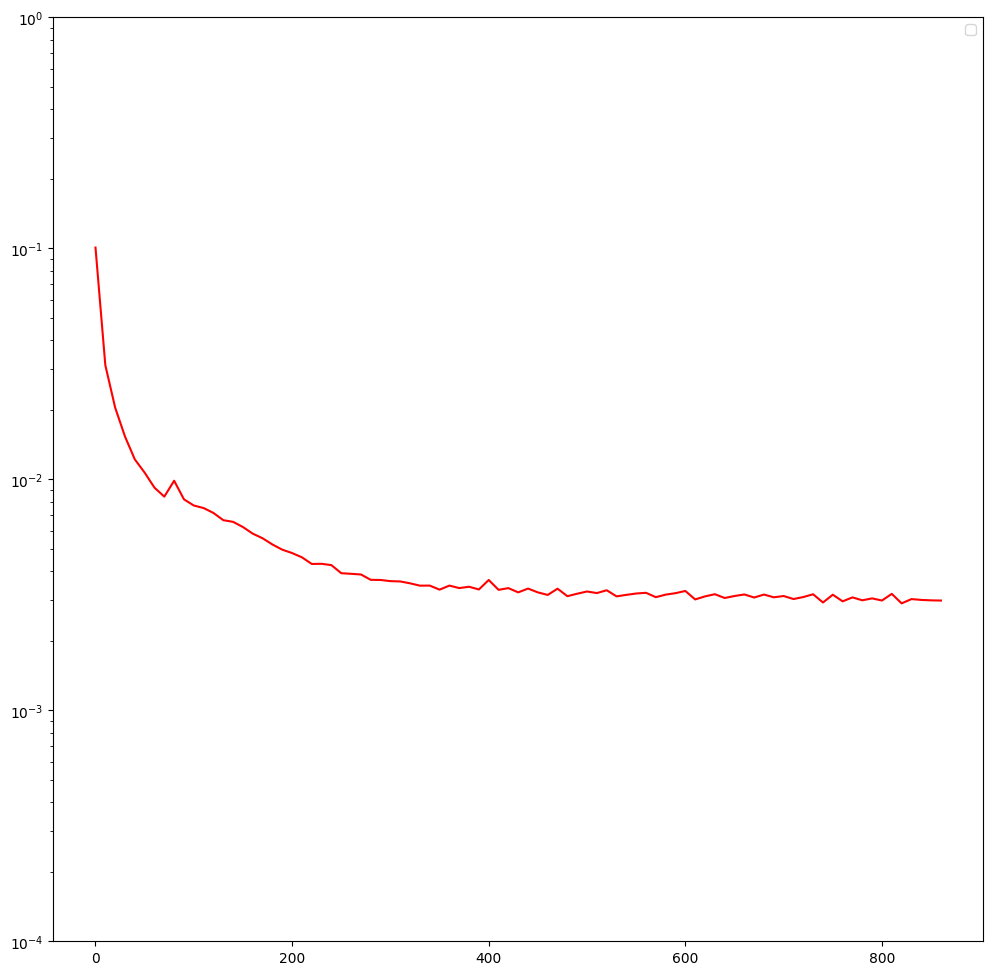

In [13]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_ylim(0.0001, 1)

def my_plot(lst: List[float], color: str, av: int):
    arr = np.array(lst)
    arr = arr[:arr.shape[0] // av * av]
    arr = arr.reshape(-1, av).mean(axis=1)
    ax.plot([i * av for i in range(arr.shape[0])], arr, c=color)

my_plot(gan_helper.losses, color='red', av=10)

ax.legend()
plt.show()

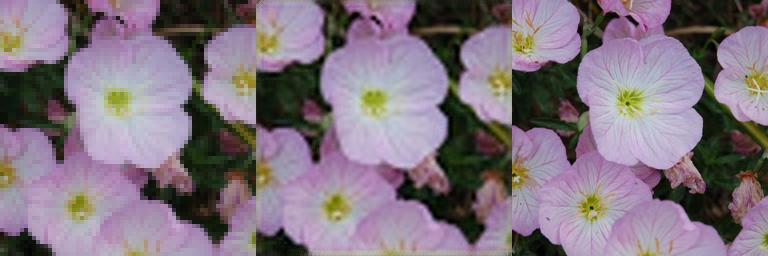

In [14]:
gan_helper.demonstrate(dataset[0])

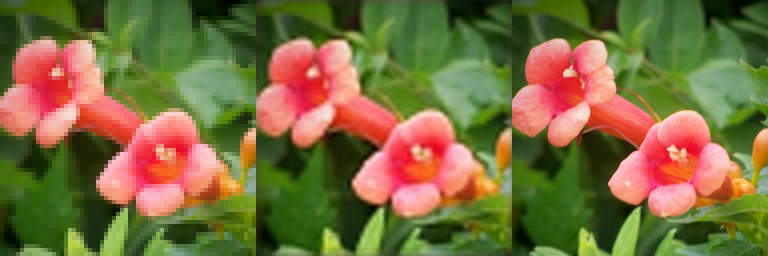

In [15]:
gan_helper.demonstrate(dataset[6])

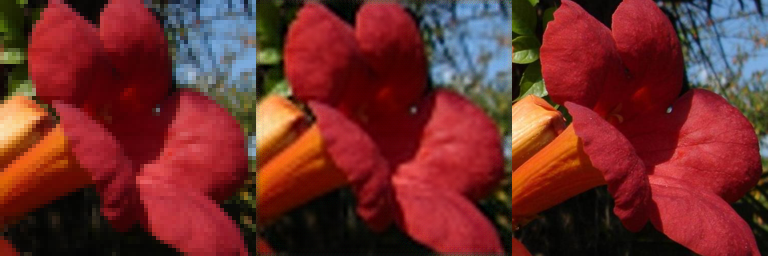

In [16]:
gan_helper.demonstrate(dataset[7])